# 1 Anomaly detection（异常检测）
使用高斯模型来检测数据集中未标记的示例是否应被视为异常。 先从简单的二维数据集开始。

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
from scipy.io import loadmat

In [2]:
data = loadmat('data/ex8data1.mat')
X = data['X']
X.shape

(307, 2)

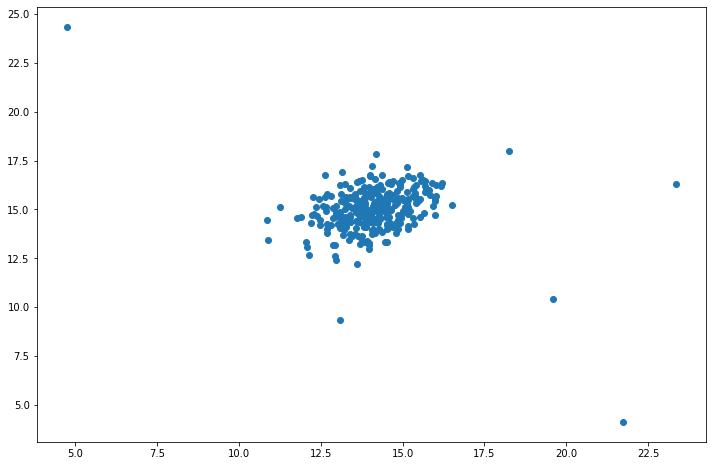

In [3]:
fig, ax = plt.subplots(figsize=(12,8))
ax.scatter(X[:,0], X[:,1])
plt.show()

In [4]:
#输入一个X矩阵，输出2个n维的向量，mu包含了每一个维度的平均值，sigma2包含了每一个维度的方差。
def estimate_gaussian(X):
    mu = X.mean(axis=0)
    sigma = X.var(axis=0)
    
    return mu, sigma

In [5]:
mu, sigma = estimate_gaussian(X)
mu, sigma

(array([14.11222578, 14.99771051]), array([1.83263141, 1.70974533]))

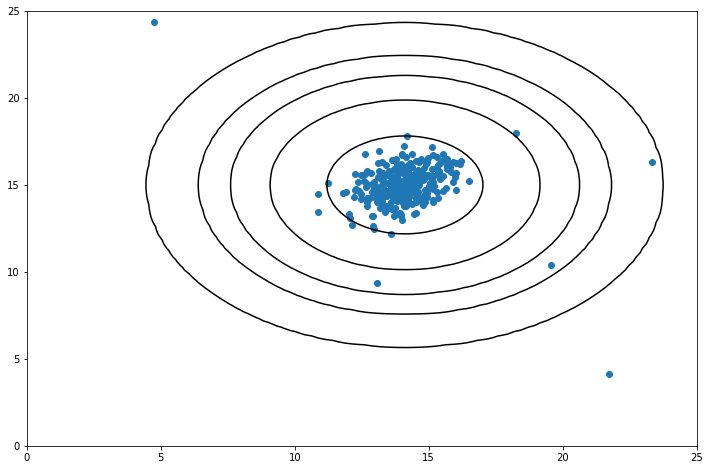

In [6]:
xplot = np.linspace(0,25,100)
yplot = np.linspace(0,25,100)
Xplot, Yplot = np.meshgrid(xplot,yplot) #从坐标向量中返回坐标矩阵
Z = np.exp((-0.5)*((Xplot-mu[0])**2/sigma[0]+(Yplot-mu[1])**2/sigma[1])) #高斯分布公式

fig, ax = plt.subplots(figsize=(12,8))
contour = plt.contour(Xplot, Yplot, Z,[10**-11, 10**-7, 10**-5, 10**-3, 0.1],colors='k')
ax.scatter(X[:,0], X[:,1])
plt.show()

#### 选择阈值ε
有了参数后，可以估计每组数据的概率，低概率的数据点更可能是异常的。确定异常点需要先确定一个阈值，我们可以通过验证集集来确定这个阈值

In [7]:
Xval = data['Xval']
yval = data['yval']

Xval.shape, yval.shape

((307, 2), (307, 1))

In [8]:
#SciPy内置一种计算数据点属于正态分布的概率的方法。
from scipy import stats
dist = stats.norm(mu[0], sigma[0])
dist.pdf(15)

0.1935875044615038

In [9]:
#将数组传递给概率密度函数，并获得数据集中每个点的概率密度
dist.pdf(X[:,0])[0:50]

array([0.183842  , 0.20221694, 0.21746136, 0.19778763, 0.20858956,
       0.21652359, 0.16991291, 0.15123542, 0.1163989 , 0.1594734 ,
       0.21716057, 0.21760472, 0.20141857, 0.20157497, 0.21711385,
       0.21758775, 0.21695576, 0.2138258 , 0.21057069, 0.1173018 ,
       0.20765108, 0.21717452, 0.19510663, 0.21702152, 0.17429399,
       0.15413455, 0.21000109, 0.20223586, 0.21031898, 0.21313426,
       0.16158946, 0.2170794 , 0.17825767, 0.17414633, 0.1264951 ,
       0.19723662, 0.14538809, 0.21766361, 0.21191386, 0.21729442,
       0.21238912, 0.18799417, 0.21259798, 0.21752767, 0.20616968,
       0.21520366, 0.1280081 , 0.21768113, 0.21539967, 0.16913173])

In [10]:
#计算并保存给定上述的高斯模型参数的数据集中每个值的概率密度。
p = np.zeros((X.shape[0], X.shape[1]))
p[:,0] = stats.norm(mu[0], sigma[0]).pdf(X[:,0])
p[:,1] = stats.norm(mu[1], sigma[1]).pdf(X[:,1])

p.shape

(307, 2)

In [11]:
#为验证集（使用相同的模型参数）执行此操作。 使用与真实标签组合的这些概率来确定将数据点分配为异常的最佳概率阈值。
pval = np.zeros((Xval.shape[0], Xval.shape[1]))
pval[:,0] = stats.norm(mu[0], sigma[0]).pdf(Xval[:,0])
pval[:,1] = stats.norm(mu[1], sigma[1]).pdf(Xval[:,1])

pval.shape

(307, 2)

In [12]:
#为找到给定概率密度值和真实标签的最佳阈值，给不同的epsilon值计算F1分数。
def select_threshold(pval, yval):
    best_epsilon = 0
    best_f1 = 0
    f1 = 0
    
    step = (pval.max() - pval.min()) / 1000
    
    for epsilon in np.arange(pval.min(), pval.max(), step): #返回一个有终点和起点的固定步长的排列
        preds = pval < epsilon
        
        tp = np.sum(np.logical_and(preds == 1, yval == 1)).astype(float) #np.logical_and：逻辑与
        fp = np.sum(np.logical_and(preds == 1, yval == 0)).astype(float)
        fn = np.sum(np.logical_and(preds == 0, yval == 1)).astype(float)
        
        precision = tp / (tp + fp)
        recall = tp / (tp + fn)
        f1 = (2 * precision * recall) / (precision + recall)
        
        if f1 > best_f1:
            best_f1 = f1
            best_epsilon = epsilon
    
    return best_epsilon, best_f1

In [13]:
epsilon, f1 = select_threshold(pval, yval)
epsilon, f1

<ipython-input-12-616f3c672ce8>:16: RuntimeWarning: invalid value encountered in double_scalars
  precision = tp / (tp + fp)


(0.009566706005956842, 0.7142857142857143)

In [14]:
#将阈值应用于数据集，并可视化结果。
outliers = np.where(p < epsilon)
outliers

(array([300, 301, 301, 303, 303, 304, 306, 306], dtype=int64),
 array([1, 0, 1, 0, 1, 0, 0, 1], dtype=int64))

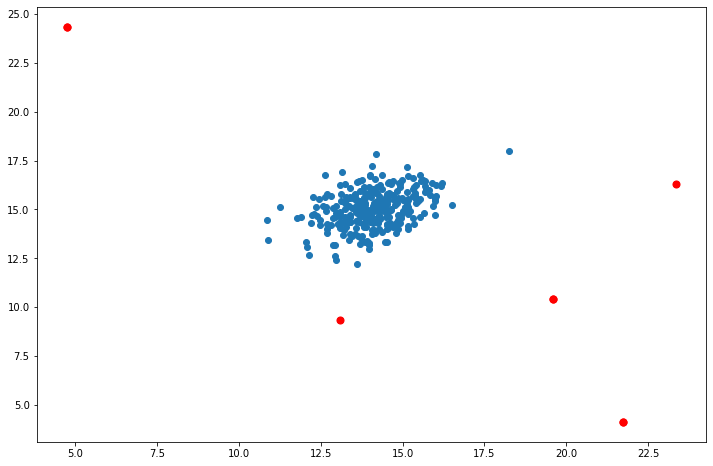

In [15]:
fig, ax = plt.subplots(figsize=(12,8))
ax.scatter(X[:,0], X[:,1])
ax.scatter(X[outliers[0],0], X[outliers[0],1], s=50, color='r', marker='o')
plt.show()
#红点是被标记为异常值的点

# 推荐系统：协同过滤
推荐引擎使用基于项目和用户的相似性度量来检查用户的历史偏好，以便为用户可能感兴趣的新“事物”提供建议。

将实现一种称为协作过滤的特定推荐系统算法，并将其应用于 电影评分的数据集。


In [16]:
data = loadmat('data/ex8_movies.mat')
data

#Y是包含从1到5的等级的数组.R是包含指示用户是否给电影评分的二进制值的“指示符”数组。 两者应该具有相同的维度。

{'__header__': b'MATLAB 5.0 MAT-file, Platform: GLNXA64, Created on: Thu Dec  1 17:19:26 2011',
 '__version__': '1.0',
 '__globals__': [],
 'Y': array([[5, 4, 0, ..., 5, 0, 0],
        [3, 0, 0, ..., 0, 0, 5],
        [4, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8),
 'R': array([[1, 1, 0, ..., 1, 0, 0],
        [1, 0, 0, ..., 0, 0, 1],
        [1, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)}

In [17]:
Y = data['Y']
R = data['R']
Y.shape, R.shape

((1682, 943), (1682, 943))

In [18]:
#通过平均排序Y来评估电影的平均评级
Y[1,np.where(R[1,:]==1)[0]].mean()

3.2061068702290076

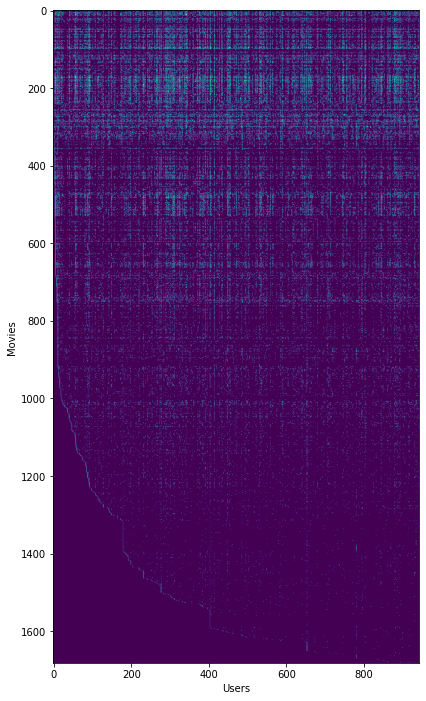

In [19]:
#将矩阵渲染成图像来尝试“可视化”数据。
ig, ax = plt.subplots(figsize=(12,12))
ax.imshow(Y)
ax.set_xlabel('Users')
ax.set_ylabel('Movies')
fig.tight_layout()
plt.show()

In [20]:
#序列化两个矩阵
def serialize(X, theta):

    # X (movie, feature), (1682, 10): movie features
    # theta (user, feature), (943, 10): user preference
    
    return np.concatenate((X.ravel(), theta.ravel())) #多个数组的拼接

#逆序列化
def deserialize(param, n_movie, n_user, n_features):
    return param[:n_movie * n_features].reshape(n_movie, n_features), param[n_movie * n_features:].reshape(n_user, n_features)


# recommendation fn
def cost(param, Y, R, n_features,l=1):
    
    """compute cost for every r(i, j)=1
    Args:
        param: serialized X, theta
        Y (movie, user), (1682, 943): (movie, user) rating
        R (movie, user), (1682, 943): (movie, user) has rating
    """
    # theta (user, feature), (943, 10): user preference
    # X (movie, feature), (1682, 10): movie features
    n_movie, n_user = Y.shape
    X, theta = deserialize(param, n_movie, n_user, n_features)

    inner = np.multiply(X @ theta.T - Y, R)
    
    reg_term = np.power(param, 2).sum() * (l / 2)
    c=np.power(inner, 2).sum() / 2
    return c+reg_term

In [21]:
params_data = loadmat('data/ex8_movieParams.mat')
X = params_data['X']
theta = params_data['Theta']
X.shape, theta.shape

((1682, 10), (943, 10))

In [22]:
#为评估时间的少点，只看一小段数据。
users = 4
movies = 5
features = 3

X_sub = X[:movies, :features]
theta_sub = theta[:users, :features]
Y_sub = Y[:movies, :users]
R_sub = R[:movies, :users]

param_sub = serialize(X_sub, theta_sub)

cost(param_sub, Y_sub, R_sub, features,l=1)

28.304238738078038

In [23]:
param = serialize(X, theta)  # total real params
cost(param_sub, Y_sub, R_sub, features, l=1.5)

31.34405624427422

In [24]:
cost(param, Y, R, 10, l=1)  # total regularized cost

32520.682450229557

#### gradient
接下来需要实现梯度计算。 像在ex4中使用神经网络实现一样，扩展代价函数来计算梯度

In [25]:
def gradient(param, Y, R, n_features,l=1):
    
    # theta (user, feature), (943, 10): user preference
    # X (movie, feature), (1682, 10): movie features
    n_movies, n_user = Y.shape
    X, theta = deserialize(param, n_movies, n_user, n_features)

    inner = np.multiply(X @ theta.T - Y, R)  # (1682, 943) 

    # X_grad (1682, 10)
    X_grad = inner @ theta #@：矩阵乘法

    # theta_grad (943, 10)
    theta_grad = inner.T @ X

    # roll them together and return
    reg_term = np.power(param, 2).sum() * (l / 2)
    g=serialize(X_grad, theta_grad)

    return g + reg_term

In [26]:
n_movie, n_user = Y.shape

X_grad, theta_grad = deserialize(gradient(param, Y, R, 10),n_movie, n_user, 10)
X_grad, theta_grad

(array([[4595.78048424, 4604.50168614, 4595.1667224 , ..., 4597.22620673,
         4605.8857409 , 4600.15445872],
        [4598.23301123, 4603.84726823, 4599.40354614, ..., 4598.48652511,
         4604.21327418, 4604.69361601],
        [4598.91142452, 4604.59086529, 4602.28117147, ..., 4597.85454049,
         4605.14770863, 4607.51556177],
        ...,
        [4600.99458398, 4603.03453344, 4601.55311669, ..., 4601.28890423,
         4602.36839891, 4601.15178932],
        [4601.25811389, 4602.80369429, 4600.78618126, ..., 4600.9918476 ,
         4603.68138003, 4601.89340607],
        [4601.65440274, 4603.1065851 , 4601.69885504, ..., 4599.99319685,
         4603.41831424, 4602.2378424 ]]),
 array([[4600.49503691, 4611.12356038, 4601.40014208, ..., 4598.12197248,
         4607.70651317, 4603.20698174],
        [4599.45402655, 4604.56574904, 4600.51829864, ..., 4596.57439078,
         4607.86712465, 4603.92731109],
        [4604.18821468, 4604.05122147, 4597.72041856, ..., 4595.20866887,

In [27]:
#创建自己的电影评分，以便我们可以使用该模型来生成个性化的推荐。提供一个连接电影索引到其标题的文件，接着我们将文件加载到字典中。

movie_list = []
f = open('data/movie_ids.txt',encoding= 'ISO-8859-1')

for line in f:
    tokens = line.strip().split(' ')
    movie_list.append(' '.join(tokens[1:]))

movie_list = np.array(movie_list)


In [28]:
movie_list[0]

'Toy Story (1995)'

In [29]:
ratings = np.zeros((1682, 1))

ratings[0] = 4
ratings[6] = 3
ratings[11] = 5
ratings[53] = 4
ratings[63] = 5
ratings[65] = 3
ratings[68] = 5
ratings[97] = 2
ratings[182] = 4
ratings[225] = 5
ratings[354] = 5

ratings.shape

(1682, 1)

In [30]:
#将自己的评级向量添加到现有数据集中以包含在模型中。
Y = data['Y']
Y = np.append(ratings,Y, axis=1)  # now I become user, append()函数用于合并两个数组
print(Y.shape)

(1682, 944)


In [31]:
R = data['R']
R = np.append( ratings != 0, R,axis=1)
R.shape

(1682, 944)

In [32]:
#不只是训练协同过滤模型。只需要定义一些变量并对评级进行规一化。
movies = Y.shape[0]  # 1682
users = Y.shape[1]  # 944
features = 10
learning_rate = 10.

X = np.random.random(size=(movies, features))
theta = np.random.random(size=(users, features))
params = serialize(X, theta)

X.shape, theta.shape, params.shape

((1682, 10), (944, 10), (26260,))

In [33]:
Y_norm = Y - Y.mean()
Y_norm.mean()

4.6862111343939375e-17

In [34]:
from scipy.optimize import minimize

fmin = minimize(fun=cost, x0=params, args=(Y_norm, R, features, learning_rate), 
                method='TNC', jac=gradient)
fmin

     fun: 164354.45710054896
     jac: array([43657.25288838, 43621.38324232, 43647.9193398 , ...,
       43796.52426922, 43807.59661344, 43814.97972157])
 message: 'Converged (|f_n-f_(n-1)| ~= 0)'
    nfev: 50
     nit: 1
  status: 1
 success: True
       x: array([0.82354806, 0.10065069, 0.16825318, ..., 0.15231596, 0.65069116,
       0.67262395])

In [35]:
#训练好的参数是X和Theta。 可以使用这些来为添加的用户创建一些建议。
X_trained, theta_trained = deserialize(fmin.x, movies, users, features)
X_trained.shape, theta_trained.shape

((1682, 10), (944, 10))

In [36]:
#最后，使用训练出的数据给出推荐电影
prediction = X_trained @ theta_trained.T
my_preds = prediction[:, 0] + Y.mean()
idx = np.argsort(my_preds)[::-1]  # Descending order
idx.shape

(1682,)

In [37]:
# top ten idx
my_preds[idx][:10]

array([3.40845367, 3.35233029, 3.3353386 , 3.3285559 , 3.28978316,
       3.25244248, 3.22523844, 3.21240938, 3.21019452, 3.18948874])

In [38]:
for m in movie_list[idx][:10]:
    print(m)

Walkabout (1971)
Maximum Risk (1996)
Primary Colors (1998)
Sleeper (1973)
Highlander III: The Sorcerer (1994)
Fire Down Below (1997)
Usual Suspects, The (1995)
Here Comes Cookie (1935)
Lay of the Land, The (1997)
Portrait of a Lady, The (1996)
